# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")

2025-08-18 05:41:45.218563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755495705.457210      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755495705.522227      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


# Check GPU Availability and TensorFlow CUDA Support

In [2]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"CUDA Available: {tf.test.is_gpu_available()}")

# Check if TensorFlow can see your GPU
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU detected and available for TensorFlow!")
    for i, gpu in enumerate(tf.config.list_physical_devices('GPU')):
        print(f"   GPU {i}: {gpu}")
        
    # Get GPU memory info
    gpu_details = tf.config.experimental.get_device_details(tf.config.list_physical_devices('GPU')[0])
    print(f"   GPU Name: {gpu_details.get('device_name', 'Unknown')}")
    
    # Enable memory growth to avoid allocating all GPU memory at once
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_virtual_device_configuration(
            gpu,
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]  # Adjust as needed
        )
else:
    print("❌ No GPU detected. Training will use CPU only.")
    print("   Make sure you have:")
    print("   - Compatible NVIDIA GPU")
    print("   - CUDA Toolkit installed")
    print("   - cuDNN installed")
    print("   - tensorflow-gpu installed")

TensorFlow version: 2.18.0
Built with CUDA: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA Available: True
✅ GPU detected and available for TensorFlow!
   GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
   GPU Name: Tesla P100-PCIE-16GB


I0000 00:00:1755495718.637848      19 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Load the preprocessed dataset

In [3]:
# Load data
# df = pd.read_csv('../../FinalDatasets/finalDataset.csv')
df = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv')
print(f"Dataset shape: {df.shape}")

# Convert DateTime to pandas datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Sort by datetime to ensure proper time order
df = df.sort_values('DateTime').reset_index(drop=True)

print("Dataset info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset shape: (14616, 36)
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning       

# Define Target Variables and Features

In [4]:
# Define target variables for prediction
target_variables = ['Temp', 'FeelsLike', 'Humidity', 'Visibility', 'SolarEnergy', 'SolarRadiation']

# Define feature variables (exclude targets and non-numeric columns)
exclude_columns = ['DateTime', 'DaySegments', 'Season', 'Conditions', 'Icon'] + target_variables
feature_variables = [col for col in df.columns if col not in exclude_columns]

print(f"Target variables ({len(target_variables)}): {target_variables}")
print(f"Feature variables ({len(feature_variables)}): {feature_variables}")

# Create feature matrix (features + targets for sequence learning)
all_variables = feature_variables + target_variables
print(f"Total variables for LSTM: {len(all_variables)}")

Target variables (6): ['Temp', 'FeelsLike', 'Humidity', 'Visibility', 'SolarEnergy', 'SolarRadiation']
Feature variables (25): ['Year', 'Month', 'Day', 'Hour', 'DaySegments_Afternoon', 'DaySegments_Early Morning', 'DaySegments_Evening', 'DaySegments_Late Night', 'DaySegments_Midday', 'DaySegments_Morning', 'DaySegments_Night', 'Season_Autumn', 'Season_Rainy', 'Season_Summer', 'Season_Winter', 'Dew', 'Precip', 'PrecipProb', 'Windgust', 'WindSpeed', 'WindDir', 'SeaLevelPressure', 'CloudCover', 'UVIndex', 'SevereRisk']
Total variables for LSTM: 31


# Prepare data for LSTM

In [5]:
# Select only numeric columns for LSTM
data = df[all_variables].copy()

# Verify data shape and types
print(f"\nData shape after preprocessing: {data.shape}")
print(f"Data types:\n{data.dtypes}")

# Display basic statistics
print("\nBasic statistics:")
print(data.describe())


Data shape after preprocessing: (14616, 31)
Data types:
Year                           int64
Month                          int64
Day                            int64
Hour                           int64
DaySegments_Afternoon          int64
DaySegments_Early Morning      int64
DaySegments_Evening            int64
DaySegments_Late Night         int64
DaySegments_Midday             int64
DaySegments_Morning            int64
DaySegments_Night              int64
Season_Autumn                  int64
Season_Rainy                   int64
Season_Summer                  int64
Season_Winter                  int64
Dew                          float64
Precip                       float64
PrecipProb                   float64
Windgust                     float64
WindSpeed                    float64
WindDir                      float64
SeaLevelPressure             float64
CloudCover                   float64
UVIndex                      float64
SevereRisk                   float64
Temp              

# Create sequences for LSTM training

In [6]:
def create_sequences(data, sequence_length, forecast_horizon, target_cols):
    """
    Create sequences for multivariate LSTM
    
    Args:
        data: DataFrame with time series data
        sequence_length: Number of time steps to look back
        forecast_horizon: Number of time steps to predict ahead
        target_cols: List of target column names
    
    Returns:
        X: Input sequences
        y: Target sequences
    """
    X, y = [], []
    
    # Get target column indices
    target_indices = [data.columns.get_loc(col) for col in target_cols]
    
    for i in range(sequence_length, len(data) - forecast_horizon + 1):
        # Input sequence (all variables)
        X.append(data.iloc[i-sequence_length:i].values)
        
        # Target sequence (only target variables for next forecast_horizon steps)
        y.append(data.iloc[i:i+forecast_horizon, target_indices].values)
    
    return np.array(X), np.array(y)

# Parameters
SEQUENCE_LENGTH = 24  # Look back 24 hours
FORECAST_HORIZON = 6  # Predict next 6 hours

print(f"Sequence length: {SEQUENCE_LENGTH} hours")
print(f"Forecast horizon: {FORECAST_HORIZON} hours")

# Create sequences
X, y = create_sequences(data, SEQUENCE_LENGTH, FORECAST_HORIZON, target_variables)

print(f"X shape: {X.shape}")  # (samples, sequence_length, features)
print(f"y shape: {y.shape}")  # (samples, forecast_horizon, targets)

Sequence length: 24 hours
Forecast horizon: 6 hours
X shape: (14587, 24, 31)
y shape: (14587, 6, 6)


# Scale the data

In [7]:
# Split data into train/validation/test
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
X_val = X[train_size:train_size + val_size]
X_test = X[train_size + val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size + val_size]
y_test = y[train_size + val_size:]

print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Scale features (X) and targets (y) separately
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Fit scalers on training data
scaler_X.fit(X_train_reshaped)

# Scale X data
X_train_scaled = scaler_X.transform(X_train_reshaped).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val_reshaped).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

# Scale y data
y_train_reshaped = y_train.reshape(-1, y_train.shape[-1])
y_val_reshaped = y_val.reshape(-1, y_val.shape[-1])
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])

scaler_y.fit(y_train_reshaped)

y_train_scaled = scaler_y.transform(y_train_reshaped).reshape(y_train.shape)
y_val_scaled = scaler_y.transform(y_val_reshaped).reshape(y_val.shape)
y_test_scaled = scaler_y.transform(y_test_reshaped).reshape(y_test.shape)

print("Data scaling completed!")

Training set: X_train: (10210, 24, 31), y_train: (10210, 6, 6)
Validation set: X_val: (2188, 24, 31), y_val: (2188, 6, 6)
Test set: X_test: (2189, 24, 31), y_test: (2189, 6, 6)
Data scaling completed!


# Build multivariate LSTM model

In [8]:
def build_lstm_model(input_shape, output_shape, lstm_units=128, dropout_rate=0.2):
    """
    Build multivariate LSTM model
    
    Args:
        input_shape: Shape of input (sequence_length, features)
        output_shape: Shape of output (forecast_horizon, targets)
        lstm_units: Number of LSTM units
        dropout_rate: Dropout rate for regularization
    
    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # First LSTM layer
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Second LSTM layer
        LSTM(lstm_units, return_sequences=True),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Third LSTM layer
        LSTM(lstm_units, return_sequences=False),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Dense layers
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        
        # Output layer - reshape to (forecast_horizon * targets)
        Dense(output_shape[0] * output_shape[1]),
        
        # Reshape to proper output shape
        tf.keras.layers.Reshape(output_shape)
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Define input and output shapes
input_shape = (SEQUENCE_LENGTH, X_train_scaled.shape[2])
output_shape = (FORECAST_HORIZON, len(target_variables))

print(f"Input shape: {input_shape}")
print(f"Output shape: {output_shape}")

# Build model
model = build_lstm_model(input_shape, output_shape)

# Display model summary
model.summary()

Input shape: (24, 31)
Output shape: (6, 6)


I0000 00:00:1755495732.611196      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        81,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         4,644 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 6)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,188 (1.59 MB)

 Trainable params: 416,420 (1.59 MB)

 Non-trainable params: 768 (3.00 KB)

# Train the LSTM model

In [9]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

# Train model

# Check device placement
with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    print(f"Training will use: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")
    
    # You can also force GPU usage (will error if no GPU available)
    # with tf.device('/GPU:0'):
    
    print("Starting model training...")
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

print("Model training completed!")

Training will use: GPU
Starting model training...
Epoch 1/100


I0000 00:00:1755495741.204396      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


320/320 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.1276 - mae: 0.2528 - val_loss: 0.0428 - val_mae: 0.1600 - learning_rate: 0.0010
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0226 - mae: 0.1098 - val_loss: 0.0153 - val_mae: 0.0903 - learning_rate: 0.0010
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0158 - mae: 0.0880 - val_loss: 0.0122 - val_mae: 0.0784 - learning_rate: 0.0010
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0129 - mae: 0.0785 - val_loss: 0.0115 - val_mae: 0.0752 - learning_rate: 0.0010
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0111 - mae: 0.0725 - val_loss: 0.0100 - val_mae: 0.0692 - learning_rate: 0.0010
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0101 - mae: 0.0688 - val_loss: 0.0106 - val_mae: 0.0703 - learning_rate: 0.0010
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0100 - mae: 0.0683 - val_loss: 0.0097 - val_mae: 0.0677 - learning_rate: 0.0010
Epo

# Evaluate model performance

In [10]:
# Make predictions
y_train_pred_scaled = model.predict(X_train_scaled)
y_val_pred_scaled = model.predict(X_val_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)

# Inverse transform predictions and actual values
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, y_train_pred_scaled.shape[-1])).reshape(y_train_pred_scaled.shape)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, y_val_pred_scaled.shape[-1])).reshape(y_val_pred_scaled.shape)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, y_test_pred_scaled.shape[-1])).reshape(y_test_pred_scaled.shape)

y_train_actual = scaler_y.inverse_transform(y_train_reshaped).reshape(y_train.shape)
y_val_actual = scaler_y.inverse_transform(y_val_reshaped).reshape(y_val.shape)
y_test_actual = scaler_y.inverse_transform(y_test_reshaped).reshape(y_test.shape)

print("Predictions completed and inverse transformed!")

320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Predictions completed and inverse transformed!


# Calculate evaluation metrics

In [11]:
def calculate_metrics(y_true, y_pred, dataset_name, target_names):
    """Calculate metrics for each target variable and forecast horizon"""
    
    print(f"\n{'='*60}")
    print(f"METRICS FOR {dataset_name.upper()} SET")
    print(f"{'='*60}")
    
    metrics_summary = {}
    
    for i, target in enumerate(target_names):
        print(f"\n{target}:")
        print("-" * 40)
        
        target_metrics = {}
        
        for hour in range(y_true.shape[1]):
            y_true_hour = y_true[:, hour, i]
            y_pred_hour = y_pred[:, hour, i]
            
            mse = mean_squared_error(y_true_hour, y_pred_hour)
            mae = mean_absolute_error(y_true_hour, y_pred_hour)
            r2 = r2_score(y_true_hour, y_pred_hour)
            
            target_metrics[f'Hour_{hour+1}'] = {
                'MSE': mse,
                'MAE': mae,
                'R2': r2
            }
            
            print(f"  Hour {hour+1}: MSE={mse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
        
        # Calculate average across all hours
        avg_mse = np.mean([target_metrics[f'Hour_{h+1}']['MSE'] for h in range(y_true.shape[1])])
        avg_mae = np.mean([target_metrics[f'Hour_{h+1}']['MAE'] for h in range(y_true.shape[1])])
        avg_r2 = np.mean([target_metrics[f'Hour_{h+1}']['R2'] for h in range(y_true.shape[1])])
        
        target_metrics['Average'] = {
            'MSE': avg_mse,
            'MAE': avg_mae,
            'R2': avg_r2
        }
        
        print(f"  Average: MSE={avg_mse:.4f}, MAE={avg_mae:.4f}, R²={avg_r2:.4f}")
        
        metrics_summary[target] = target_metrics
    
    return metrics_summary

# Calculate metrics for all datasets
train_metrics = calculate_metrics(y_train_actual, y_train_pred, "Training", target_variables)
val_metrics = calculate_metrics(y_val_actual, y_val_pred, "Validation", target_variables)
test_metrics = calculate_metrics(y_test_actual, y_test_pred, "Test", target_variables)


METRICS FOR TRAINING SET

Temp:
----------------------------------------
  Hour 1: MSE=603632.9128, MAE=762.4393, R²=-24.5062
  Hour 2: MSE=603812.7902, MAE=762.5460, R²=-24.5207
  Hour 3: MSE=603800.6734, MAE=762.5308, R²=-24.5250
  Hour 4: MSE=603693.7448, MAE=762.4746, R²=-24.5249
  Hour 5: MSE=603589.9878, MAE=762.4125, R²=-24.5285
  Hour 6: MSE=603479.4646, MAE=762.3310, R²=-24.5306
  Average: MSE=603668.2623, MAE=762.4557, R²=-24.5226

FeelsLike:
----------------------------------------
  Hour 1: MSE=1368861.3680, MAE=1133.3745, R²=-14.5657
  Hour 2: MSE=1369111.0376, MAE=1133.4697, R²=-14.5719
  Hour 3: MSE=1368812.3749, MAE=1133.3422, R²=-14.5711
  Hour 4: MSE=1368539.0250, MAE=1133.2380, R²=-14.5706
  Hour 5: MSE=1368249.5624, MAE=1133.1220, R²=-14.5714
  Hour 6: MSE=1368080.5921, MAE=1133.0279, R²=-14.5733
  Average: MSE=1368608.9933, MAE=1133.2624, R²=-14.5707

Humidity:
----------------------------------------
  Hour 1: MSE=31651814.5297, MAE=5515.4697, R²=-24.2370
  Hour 

# Plot training history

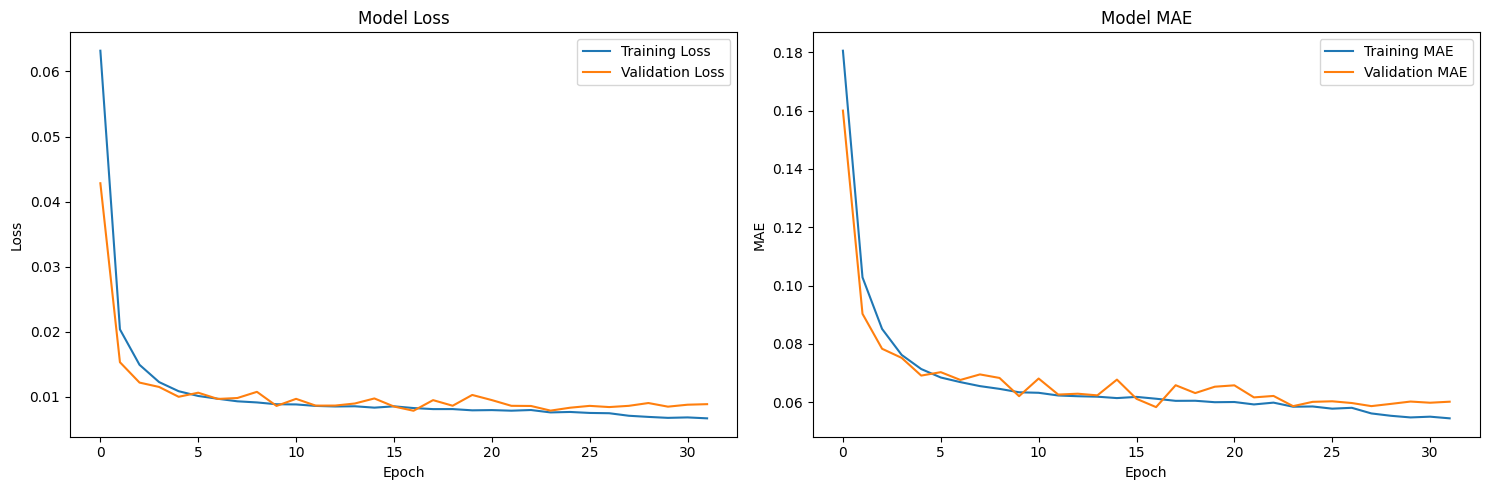

In [12]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize predictions for each target variable

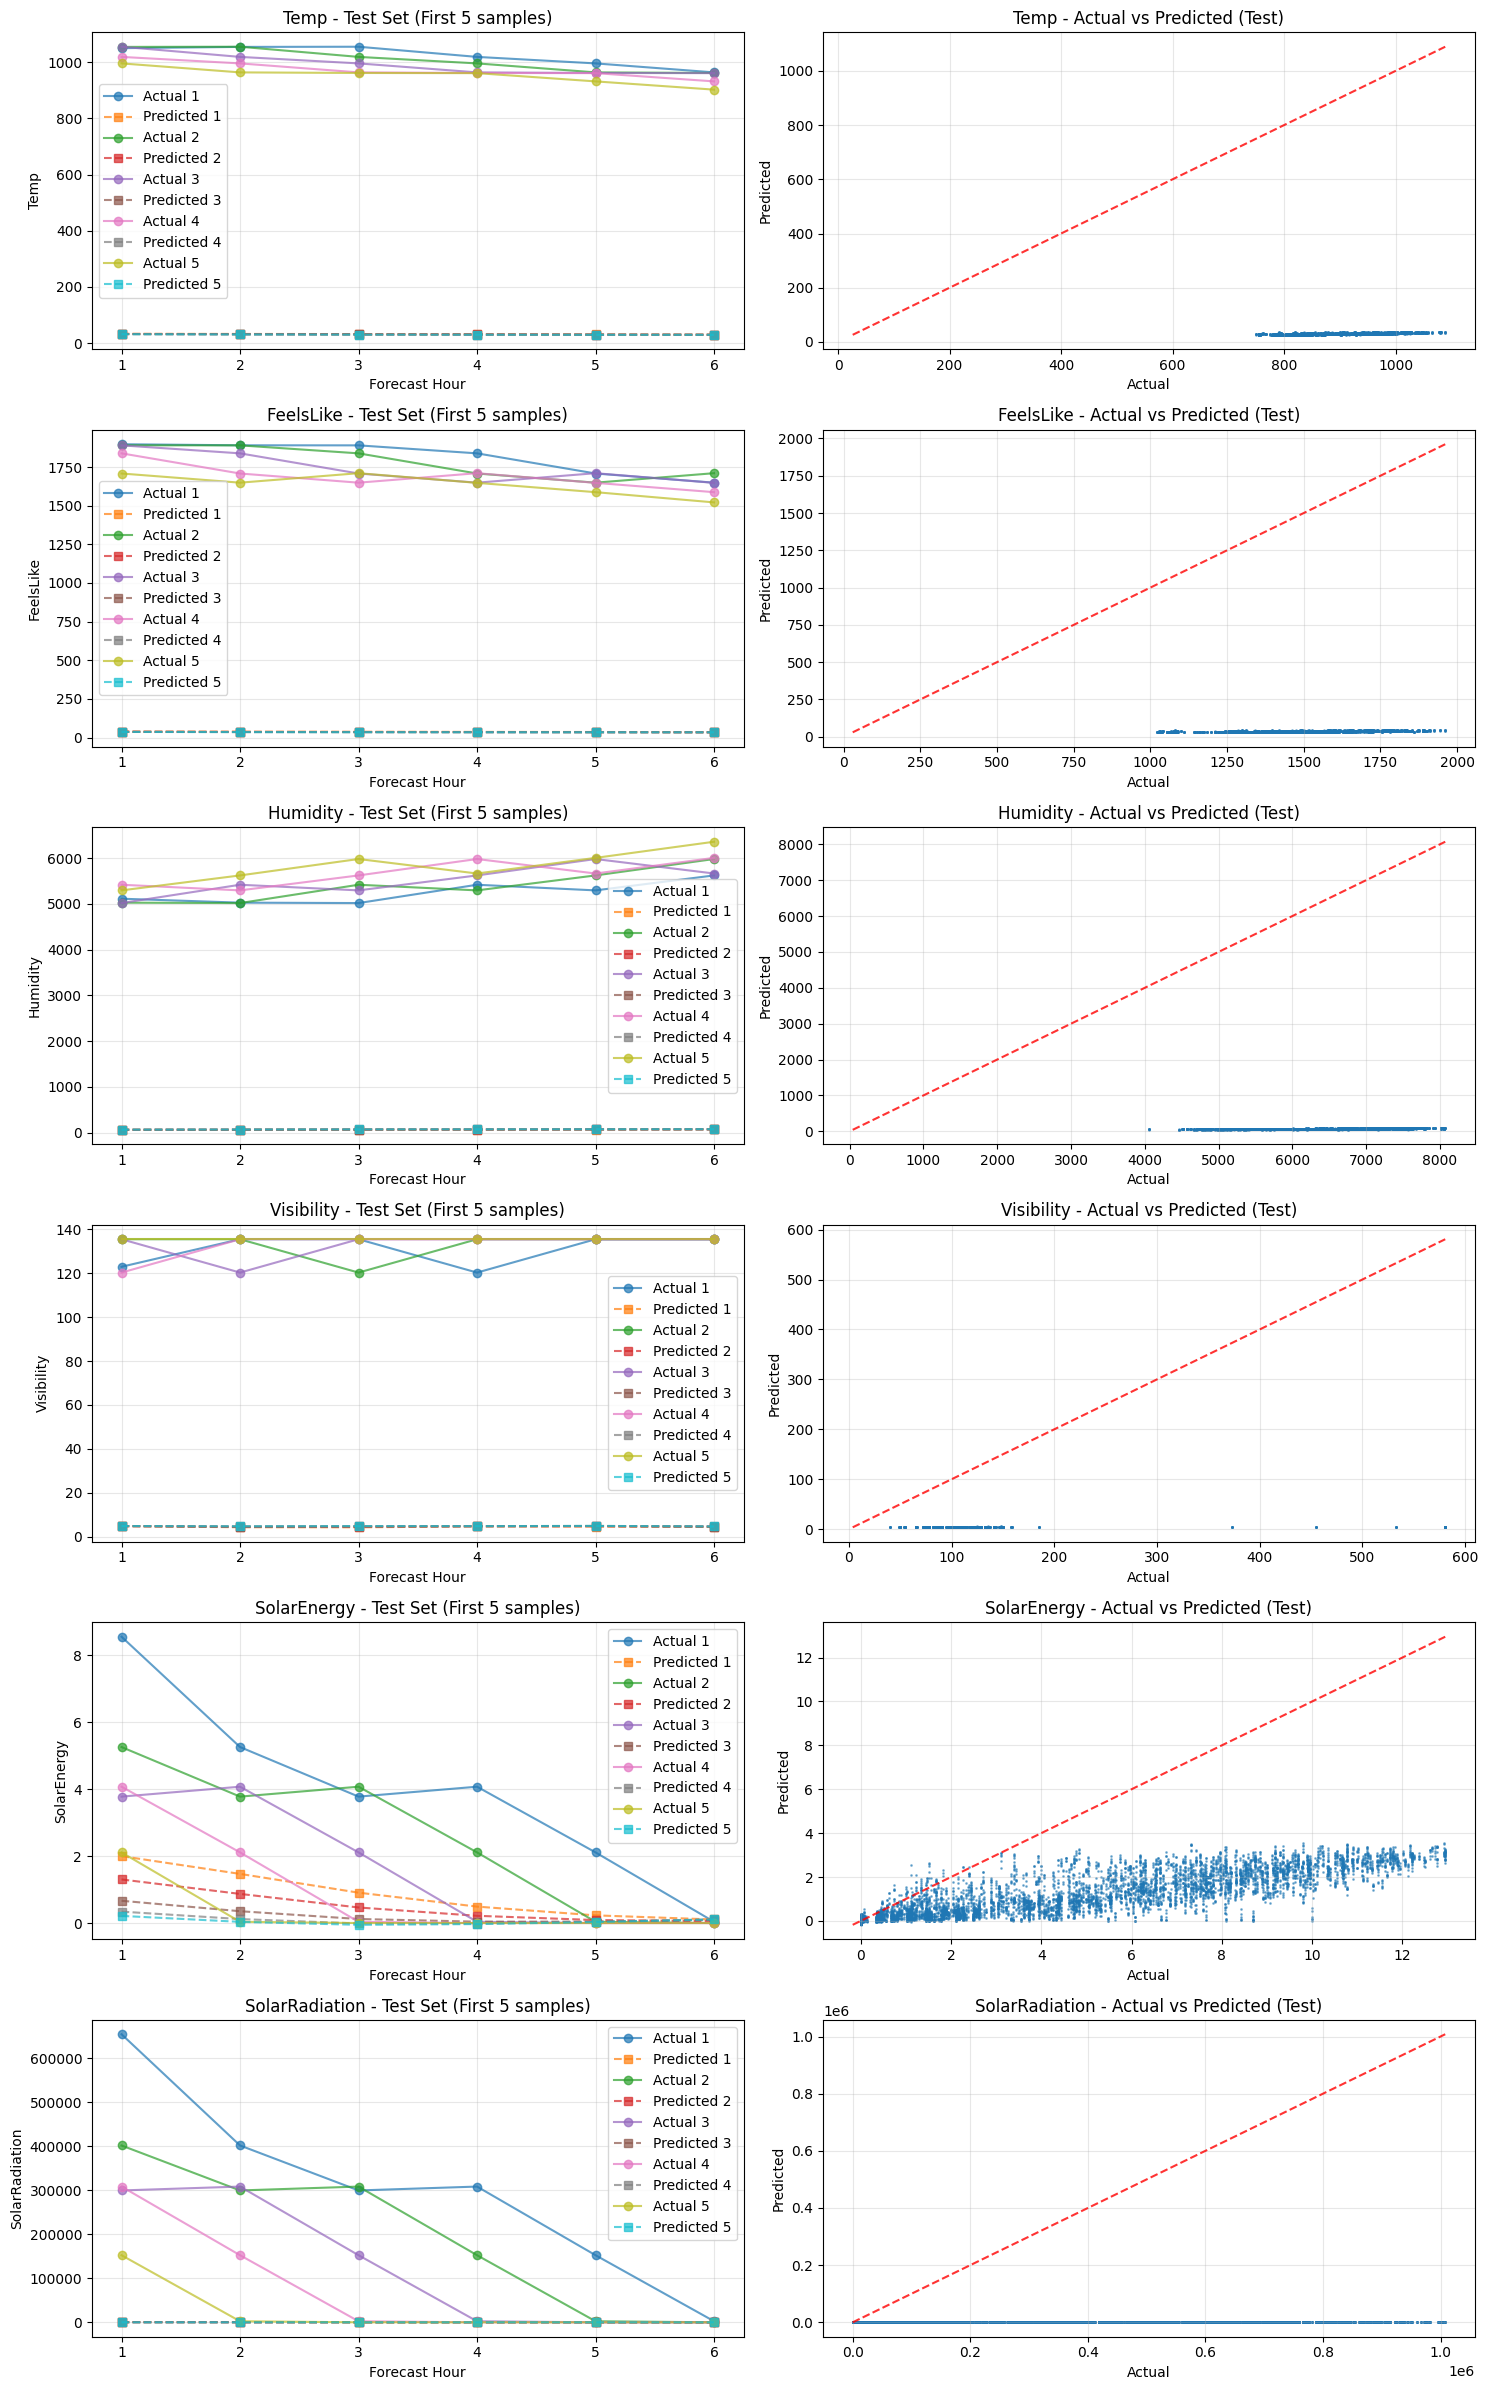

In [13]:
def plot_predictions(y_true, y_pred, target_names, dataset_name, n_samples=5):
    """Plot predictions vs actual values for each target variable"""
    
    fig, axes = plt.subplots(len(target_names), 2, figsize=(15, 4*len(target_names)))
    
    for i, target in enumerate(target_names):
        # Plot time series for first few samples
        ax1 = axes[i, 0] if len(target_names) > 1 else axes[0]
        for sample in range(min(n_samples, y_true.shape[0])):
            hours = range(1, y_true.shape[1] + 1)
            ax1.plot(hours, y_true[sample, :, i], 'o-', alpha=0.7, label=f'Actual {sample+1}')
            ax1.plot(hours, y_pred[sample, :, i], 's--', alpha=0.7, label=f'Predicted {sample+1}')
        
        ax1.set_title(f'{target} - {dataset_name} Set (First {n_samples} samples)')
        ax1.set_xlabel('Forecast Hour')
        ax1.set_ylabel(target)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Scatter plot for all predictions vs actual
        ax2 = axes[i, 1] if len(target_names) > 1 else axes[1]
        y_true_flat = y_true[:, :, i].flatten()
        y_pred_flat = y_pred[:, :, i].flatten()
        
        ax2.scatter(y_true_flat, y_pred_flat, alpha=0.5, s=1)
        
        # Perfect prediction line
        min_val = min(y_true_flat.min(), y_pred_flat.min())
        max_val = max(y_true_flat.max(), y_pred_flat.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        
        ax2.set_title(f'{target} - Actual vs Predicted ({dataset_name})')
        ax2.set_xlabel('Actual')
        ax2.set_ylabel('Predicted')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot predictions for test set
plot_predictions(y_test_actual, y_test_pred, target_variables, "Test")

# Save the trained model and scalers

In [14]:
import joblib
import os

# Create directory for saving models
os.makedirs('LSTM_Models', exist_ok=True)

# Save the Keras model
model.save('LSTM_Models/multivariate_lstm_weather_model.h5')

# Save the scalers
joblib.dump(scaler_X, 'LSTM_Models/scaler_X.pkl')
joblib.dump(scaler_y, 'LSTM_Models/scaler_y.pkl')

# Save model configuration
model_config = {
    'sequence_length': SEQUENCE_LENGTH,
    'forecast_horizon': FORECAST_HORIZON,
    'target_variables': target_variables,
    'feature_variables': feature_variables,
    'input_shape': input_shape,
    'output_shape': output_shape
}

joblib.dump(model_config, 'LSTM_Models/model_config.pkl')

print("Model and scalers saved successfully!")
print("Files saved:")
print("- LSTM_Models/multivariate_lstm_weather_model.h5")
print("- LSTM_Models/scaler_X.pkl")
print("- LSTM_Models/scaler_y.pkl")
print("- LSTM_Models/model_config.pkl")

Model and scalers saved successfully!
Files saved:
- LSTM_Models/multivariate_lstm_weather_model.h5
- LSTM_Models/scaler_X.pkl
- LSTM_Models/scaler_y.pkl
- LSTM_Models/model_config.pkl


# Function to make predictions on new data

In [15]:
def predict_next_6_hours(recent_data, model, scaler_X, scaler_y, sequence_length=24):
    """
    Predict next 6 hours of weather variables
    
    Args:
        recent_data: DataFrame with last 24 hours of data
        model: Trained LSTM model
        scaler_X: Fitted scaler for features
        scaler_y: Fitted scaler for targets
        sequence_length: Number of hours to look back
    
    Returns:
        DataFrame with predictions for next 6 hours
    """
    # Ensure we have enough data
    if len(recent_data) < sequence_length:
        raise ValueError(f"Need at least {sequence_length} hours of recent data")
    
    # Get last sequence_length hours
    input_data = recent_data[all_variables].iloc[-sequence_length:].values
    
    # Scale the input data
    input_scaled = scaler_X.transform(input_data.reshape(1, -1)).reshape(1, sequence_length, -1)
    
    # Make prediction
    pred_scaled = model.predict(input_scaled)
    
    # Inverse transform prediction
    pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, pred_scaled.shape[-1])).reshape(pred_scaled.shape)
    
    # Create DataFrame with predictions
    future_hours = pd.date_range(
        start=recent_data['DateTime'].iloc[-1] + pd.Timedelta(hours=1),
        periods=6,
        freq='H'
    )
    
    predictions_df = pd.DataFrame(
        pred[0],
        columns=target_variables,
        index=future_hours
    )
    
    return predictions_df

# Example usage (you can test this with your data)
print("Prediction function created!")
print("Use predict_next_6_hours(recent_data, model, scaler_X, scaler_y) to make predictions")

Prediction function created!
Use predict_next_6_hours(recent_data, model, scaler_X, scaler_y) to make predictions
